# Obligatorio - Taller Agentes Inteligentes 2023

Vamos a usar el juego Super Mario Bros:
PyPi: https://pypi.org/project/gym-super-mario-bros/ 
Repo: https://github.com/Kautenja/gym-super-mario-bros

En este caso, el juego está programado como un ambiente de OpenAI Gym, cumpliendo con las interfaces que hemos trabajado en el curso.


El objetivo del juego consta de lograr que nuestro personaje llegue al final de la pantalla, sin ser comido por enemigos o caer al vacío.

![](./assets/images/mario.gif)

Si bien el juego podría considerarse de múltiples agentes (mario, y sus enemigos), utilizaremos unicamente las heramientas del curso para solucionarlo, esto es, todo lo que no conforma a nuestros agentes será considerado ambiente y tratado como tal.

El objetivo es resolver el juego utilizando Deep Q Learning y Double Deep Q Learning, comparando sus resultados.


## Tareas:


1. Completar el código faltante en este notebook (y archivos asociados).


2. Entrenar un agente de Deep Q Learning (DQN) para cada ambiente tal que éste sea capaz de resolverlo.


3. Entrenar un agente de Double Deep Q Learning (DDQN) para cada ambiente tal que éste sea capaz de resolverlo.


4. Graficar las recompensas obtenidas para cada ambiente por cada agente (Ambos agentes resolviendo el ambiente 1 en una misma gráfica, idem para el ambiente 2). Escribir al menos 2 conclusiones de cada grafica. 


5. Grabar un video de cada agente resolviendo cada problema (pueden descargar el video desde colab y entregarlos dentro de un zip).


Recuerden que pueden usar la GPU en google colab para agilizar el entrenamiento. 
***


Fecha de entrega: **04/07** 21hs por gestión (gestion.ort.edu.uy). Pueden trabajar en grupos de hasta 3 estudiantes. 
***

Instalación de librerías. Se fija la versión de gym, dado que para dicha versión las ROMS de los juegos ya estan includias y se evita su instalación separada lo que puede originar problemas.

In [1]:
#%%capture
#!pip install pyvirtualdisplay > /dev/null 2>&1
#!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
#!pip install opencv-python
#!pip install torchsummary
#!pip install nes-py
#!pip install --force-reinstall gym-super-mario-bros==7.4.0  > /dev/null 2>&1
#!pip install --force-reinstall gym==0.15.3 > /dev/null 2>&1
#!pip install pillow==8.4.0
#!pip install torchvision==0.11.1
#!pip install pyglet==1.4.9
#!pip install torch==1.8.1+cu101 torchvision==0.9.1+cu101 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Imports y configuraciones de ambiente

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

import math
import random
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import mario_utils
from replay_memory import ReplayMemory
from abstract_agent import Agent
import gym
from dqn_cnn_model import DQN_CNN_Model
import warnings
warnings.filterwarnings("ignore")

Checkeo de devices

In [3]:
torch.zeros(1).cuda()

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Running on {DEVICE}")

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

print("Cuda Available:", torch.cuda.is_available(), '====>',
torch.cuda.get_device_name(torch.cuda.current_device()))

Running on cuda:0
Cuda Available: True ====> NVIDIA GeForce RTX 4060 Laptop GPU


Setting de seeds

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

Validacion del ambiente

In [5]:
ENV_NAME = "SuperMarioBros-1-1-v0"

env = mario_utils.make_env(ENV_NAME)
print("Actions #",env.action_space.n)
print(env.unwrapped.get_action_meanings())
print(env.observation_space.shape)
env.reset()
next_state, reward, done, info = env.step(action=0)

print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

Actions # 2
['NOOP']
(4, 84, 84)
(4, 84, 84),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


In [6]:
next_state, reward, done, info = env.step(action=0)
torch.Tensor(next_state[:])

tensor([[[0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         [0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         [0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         ...,
         [0.4862, 0.4862, 0.4862,  ..., 0.4862, 0.5114, 0.4862],
         [0.7494, 0.3820, 0.3579,  ..., 0.2038, 0.4862, 0.4862],
         [0.4515, 0.4515, 0.1305,  ..., 0.7431, 0.4515, 0.0107]],

        [[0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         [0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         [0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         ...,
         [0.4862, 0.4862, 0.4862,  ..., 0.4862, 0.5114, 0.4862],
         [0.7494, 0.3820, 0.3579,  ..., 0.2038, 0.4862, 0.4862],
         [0.4515, 0.4515, 0.1305,  ..., 0.7431, 0.4515, 0.0107]],

        [[0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         [0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         [0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.

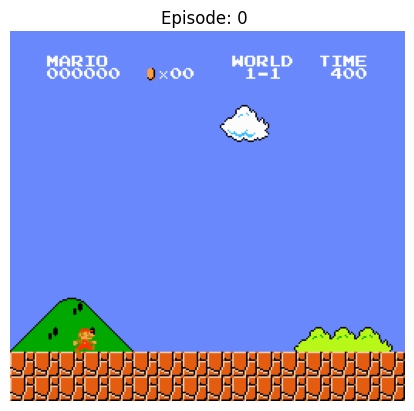

In [7]:
mario_utils.show_state(env)

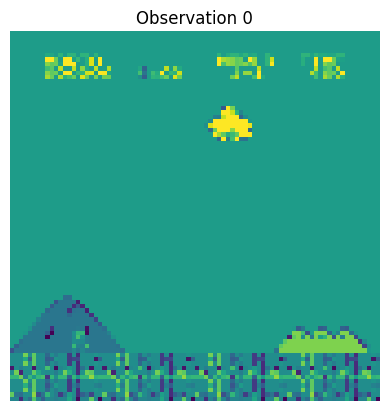

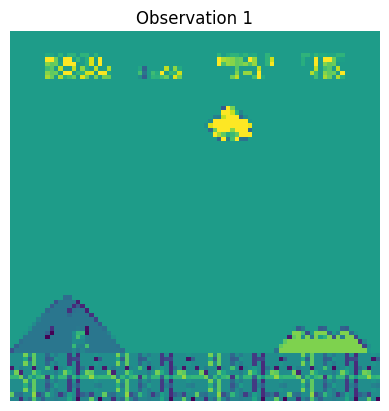

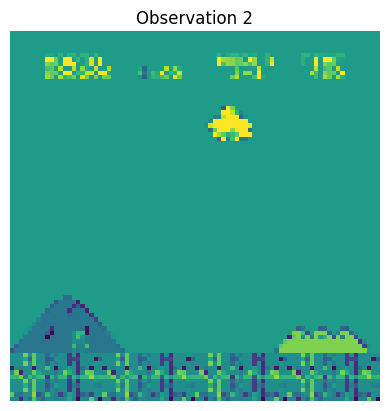

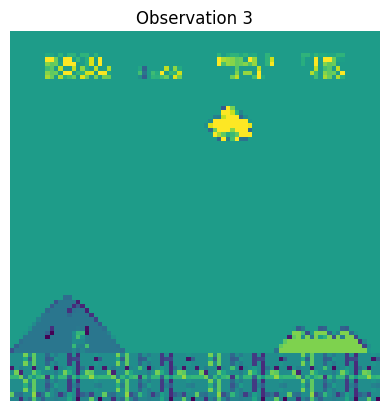

In [8]:
obs = env.reset()
mario_utils.show_obs(obs)

In [9]:
from IPython.display import HTML
from pyvirtualdisplay import Display

#display = Display(visible=0, size=(1400, 900),color_depth=16)
#display.start()

wrapped_env = mario_utils.wrap_env(env)
state = wrapped_env.reset()

while True:        
  #wrapped_env.render()
  state, reward, done, info = wrapped_env.step(wrapped_env.action_space.sample())
  if done:
    break

wrapped_env.close()

In [10]:
mario_utils.show_video()

# Deep Q Learning


Recomendamos empezar implementando Deep Q Learning (paper presentado por DeepMind, pueden encontrar el mismo en arxiv: https://arxiv.org/pdf/1312.5602.pdf0).

***

En las celdas siguientes dejamos el código que deben implementar asi como una explicación del mismo.

# Memoria

El algoritmo de Deep Q Learning presentado en el paper utiliza una memoria (llamada Replay Memory) para almacenar transiciones pasadas. Tuplas que contienen un estado base, la accion tomada, la recompensa obtenida, una bandera que indica si el siguiente estado es final o no; y el estado siguiente.

Esta memoria es circular, es decir, tiene un límite maximo de elementos y una vez esté llena comienza a reemplazar los elementos más viejos.

Vamos a necesitar crear una función **sample** que obtiene una mustra aleatoria de elementos de la memoria.  Esto puede ser una lista de Transiciones o listas separadas (pero alineadas) de los elementos que las componen.

***

Para implementar esta funcionalidad se debe modificar el archivo **replay_memory.py**


In [11]:
from replay_memory import ReplayMemory
buffer_size = 100
memory = ReplayMemory(buffer_size)

def process_state(obs):
    return torch.from_numpy(np.array(obs)).unsqueeze(0).cpu().to(DEVICE)

# Modelo

Vamos a usar un mismo modelo FeedForward para estos dos problemas (entrenado en cada problema particular). Recomendamos simplicidad en la creación del mismo, pero tienen total libertad al momento de implementarlo.

***
Para implementar esta funcionalidad se debe modificar el archivo **dqn_cnn_model.py**


In [12]:
from dqn_cnn_model import DQN_CNN_Model
from mario_utils import make_env

test_env = make_env(ENV_NAME)

input_channels = test_env.observation_space.shape[0]
test_net = DQN_CNN_Model(input_channels, test_env.action_space.n).to(DEVICE)

from torchsummary import summary
summary(test_net, test_env.observation_space.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 20, 20]           4,112
              ReLU-2           [-1, 16, 20, 20]               0
            Conv2d-3             [-1, 32, 9, 9]           8,224
              ReLU-4             [-1, 32, 9, 9]               0
            Linear-5                  [-1, 256]         663,808
            Linear-6                    [-1, 2]             514
Total params: 676,658
Trainable params: 676,658
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.14
Params size (MB): 2.58
Estimated Total Size (MB): 2.83
----------------------------------------------------------------


# Agente

Vamos a definir una clase agente, encargado de interactuar con el ambiente y entrenar los modelos. Los métdos definidos deben funcionar para ambos problemas simplemente cambiando el modelo a utilizar para cada ambiente.

Abajo dejamos un esqueleto del mismo y las funciones a completar. Recomendamos no alterar la estructura del mismo, pero pueden definir las funciones auxiliares que consideren necesarias.

Una aclaracion particular es sobre los últimos tres parametros del agente, representan los valores de epsilon_inicial, epsilon_final y el tiempo (numero de steps) que tardamos en llegar del epsilon final al inicial (puede decrementarlo de forma lineal o exponencial en el número de steps).

***

Para implementar esta funcionalidad se debe modificar los archivos **abstract_agent.py**, **dqn_agent.py** y **double_dqn_agent.py**.

Funciones a completar:


1. init: que inicializa los parametros del agente.

2. compute_epsilon: que computa el valor actual de epsilon en base al número de pasos actuales.

3. select_action: Seleccionando acciones "epsilongreedy-mente" si estamos entranando y completamente greedy en otro caso.

4. train: que entrena el agente por un número dado de episodios de largo determinado.

5. record_test_episode: para grabar un episodio con el agente siempre seleccionando la mejor accion conocida.

# Entrenamiento

Para entrenar van a necesitar definir:

1. El ambiente.
2. Una instancia del modelo a utilizar para el problema (ej: `mario_model = DQNModel(espacio_obs, num_acciones)`.
3. La función para procesar los estados (phi en el paper) que es necesaria para poder usar el modelo de Pytorch con las representaciones de gym.

Una vez definido pueden llamar a la función train del agente para entrenarlo y problar las demás funciones.

***

Una de las cosas que recomendamos hacer para probar los algoritmos es entrenar el agente por una cantidad X de episodios, grabar un video para observar progreso, volver a entrenar el mismo agente y volver a grabar un video, todas las veces que considere necesario.

***

In [13]:
%load_ext tensorboard

In [14]:
#Hiperparámetros de entrenamiento del agente DQN
TOTAL_STEPS =1000000
EPISODES = 50
STEPS = 100000

EPSILON_INI = 1
EPSILON_MIN = 0.02
EPSILON_DECAY = 0.99998599985
EPSILON_TIME = max(1, int(EPISODES * 0.9))
EPISODE_BLOCK = 20

BATCH_SIZE = 128
BUFFER_SIZE = 30000

GAMMA = 0.99
LEARNING_RATE = 1e-4

In [15]:
from dqn_agent import DQNAgent
env = mario_utils.make_env(ENV_NAME)

# Cada vez que hacemos un experimento reseteamos la semilla para tener reproducibilidad
env.seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

net = DQN_CNN_Model(test_env.observation_space.shape[0], 2).to(DEVICE)

ruta_archivo = "/mnt/c/Users/crisd/OneDrive/Escritorio/python/mario/letra/obligatorio/modelo_pesos.pth"
net.load_state_dict(torch.load(ruta_archivo))

#gym_env, model, obs_processing_func, memory_buffer_size, batch_size, learning_rate, gamma, epsilon_i, epsilon_f, epsilon_anneal_time
agent = DQNAgent(env, net, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i= EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_time=EPSILON_TIME, epsilon_decay = EPSILON_DECAY, episode_block = EPISODE_BLOCK)

rewards = agent.train(EPISODES, STEPS, TOTAL_STEPS, writer_name = ENV_NAME)

torch.save(net.state_dict(), ruta_archivo,)

  2%|▏         | 1/50 [00:02<02:07,  2.59s/ episodes]

Episode 0 - Avg. Reward over the last 20 episodes 790.000 epsilon 1.00 total steps 267
Episode 1 - Avg. Reward over the last 20 episodes 790.000 epsilon 1.00 total steps 267


  4%|▍         | 2/50 [00:06<02:35,  3.24s/ episodes]

Episode 2 - Avg. Reward over the last 20 episodes 730.500 epsilon 0.98 total steps 636


  6%|▌         | 3/50 [00:10<02:54,  3.71s/ episodes]

Episode 3 - Avg. Reward over the last 20 episodes 907.667 epsilon 0.96 total steps 1050


  8%|▊         | 4/50 [00:11<02:05,  2.72s/ episodes]

Episode 4 - Avg. Reward over the last 20 episodes 834.500 epsilon 0.93 total steps 1166


 10%|█         | 5/50 [00:15<02:15,  3.01s/ episodes]

Episode 5 - Avg. Reward over the last 20 episodes 870.200 epsilon 0.91 total steps 1510


 12%|█▏        | 6/50 [00:15<01:33,  2.13s/ episodes]

Episode 6 - Avg. Reward over the last 20 episodes 763.667 epsilon 0.89 total steps 1550


 14%|█▍        | 7/50 [00:19<01:51,  2.60s/ episodes]

Episode 7 - Avg. Reward over the last 20 episodes 838.286 epsilon 0.87 total steps 1887


 16%|█▌        | 8/50 [00:19<01:20,  1.91s/ episodes]

Episode 8 - Avg. Reward over the last 20 episodes 762.375 epsilon 0.85 total steps 1927


 18%|█▊        | 9/50 [00:20<01:08,  1.67s/ episodes]

Episode 9 - Avg. Reward over the last 20 episodes 745.556 epsilon 0.83 total steps 2036


 20%|██        | 10/50 [00:23<01:18,  1.96s/ episodes]

Episode 10 - Avg. Reward over the last 20 episodes 773.500 epsilon 0.80 total steps 2278


 22%|██▏       | 11/50 [00:26<01:26,  2.21s/ episodes]

Episode 11 - Avg. Reward over the last 20 episodes 821.273 epsilon 0.78 total steps 2538


 24%|██▍       | 12/50 [00:27<01:13,  1.94s/ episodes]

Episode 12 - Avg. Reward over the last 20 episodes 803.833 epsilon 0.76 total steps 2660


 26%|██▌       | 13/50 [00:28<00:55,  1.49s/ episodes]

Episode 13 - Avg. Reward over the last 20 episodes 759.769 epsilon 0.74 total steps 2700


 28%|██▊       | 14/50 [00:29<00:51,  1.44s/ episodes]

Episode 14 - Avg. Reward over the last 20 episodes 750.286 epsilon 0.72 total steps 2811


 30%|███       | 15/50 [00:32<01:07,  1.93s/ episodes]

Episode 15 - Avg. Reward over the last 20 episodes 768.867 epsilon 0.70 total steps 3072


 32%|███▏      | 16/50 [00:33<01:01,  1.81s/ episodes]

Episode 16 - Avg. Reward over the last 20 episodes 758.438 epsilon 0.67 total steps 3190


 34%|███▍      | 17/50 [00:37<01:16,  2.31s/ episodes]

Episode 17 - Avg. Reward over the last 20 episodes 790.588 epsilon 0.65 total steps 3433


 36%|███▌      | 18/50 [00:39<01:10,  2.19s/ episodes]

Episode 18 - Avg. Reward over the last 20 episodes 786.333 epsilon 0.63 total steps 3569


 38%|███▊      | 19/50 [00:39<00:52,  1.70s/ episodes]

Episode 19 - Avg. Reward over the last 20 episodes 757.105 epsilon 0.61 total steps 3609


 40%|████      | 20/50 [00:42<01:03,  2.10s/ episodes]

Episode 20 - Avg. Reward over the last 20 episodes 771.000 epsilon 0.59 total steps 3840


 42%|████▏     | 21/50 [00:44<00:55,  1.92s/ episodes]

Episode 20 - Avg. Reward over the last 20 episodes 761.950 epsilon 0.56 total steps 3951
Episode 21 - Avg. Reward over the last 20 episodes 761.950 epsilon 0.56 total steps 3951


 44%|████▍     | 22/50 [00:47<01:05,  2.33s/ episodes]

Episode 22 - Avg. Reward over the last 20 episodes 780.000 epsilon 0.54 total steps 4171


 46%|████▌     | 23/50 [00:48<00:48,  1.79s/ episodes]

Episode 23 - Avg. Reward over the last 20 episodes 728.450 epsilon 0.52 total steps 4211


 48%|████▊     | 24/50 [00:51<00:58,  2.23s/ episodes]

Episode 24 - Avg. Reward over the last 20 episodes 749.600 epsilon 0.50 total steps 4429


 50%|█████     | 25/50 [00:54<01:00,  2.41s/ episodes]

Episode 25 - Avg. Reward over the last 20 episodes 736.100 epsilon 0.48 total steps 4621


 52%|█████▏    | 26/50 [00:55<00:45,  1.89s/ episodes]

Episode 26 - Avg. Reward over the last 20 episodes 736.100 epsilon 0.46 total steps 4661


 54%|█████▍    | 27/50 [00:55<00:35,  1.54s/ episodes]

Episode 27 - Avg. Reward over the last 20 episodes 683.350 epsilon 0.43 total steps 4701


 56%|█████▌    | 28/50 [00:58<00:41,  1.88s/ episodes]

Episode 28 - Avg. Reward over the last 20 episodes 724.050 epsilon 0.41 total steps 4890


 58%|█████▊    | 29/50 [00:58<00:31,  1.49s/ episodes]

Episode 29 - Avg. Reward over the last 20 episodes 705.050 epsilon 0.39 total steps 4930


 60%|██████    | 30/50 [00:59<00:24,  1.23s/ episodes]

Episode 30 - Avg. Reward over the last 20 episodes 665.350 epsilon 0.37 total steps 4970


 62%|██████▏   | 31/50 [01:03<00:37,  1.95s/ episodes]

Episode 31 - Avg. Reward over the last 20 episodes 652.150 epsilon 0.35 total steps 5201


 64%|██████▍   | 32/50 [01:06<00:43,  2.40s/ episodes]

Episode 32 - Avg. Reward over the last 20 episodes 673.400 epsilon 0.32 total steps 5430


 66%|██████▌   | 33/50 [01:09<00:44,  2.64s/ episodes]

Episode 33 - Avg. Reward over the last 20 episodes 738.750 epsilon 0.30 total steps 5709


 68%|██████▊   | 34/50 [01:10<00:31,  1.98s/ episodes]

Episode 34 - Avg. Reward over the last 20 episodes 718.950 epsilon 0.28 total steps 5749


 70%|███████   | 35/50 [01:12<00:31,  2.10s/ episodes]

Episode 35 - Avg. Reward over the last 20 episodes 719.500 epsilon 0.26 total steps 5943


 72%|███████▏  | 36/50 [01:13<00:22,  1.62s/ episodes]

Episode 36 - Avg. Reward over the last 20 episodes 700.950 epsilon 0.24 total steps 5983


 74%|███████▍  | 37/50 [01:14<00:20,  1.54s/ episodes]

Episode 37 - Avg. Reward over the last 20 episodes 667.000 epsilon 0.22 total steps 6081


 76%|███████▌  | 38/50 [01:22<00:39,  3.31s/ episodes]

Episode 38 - Avg. Reward over the last 20 episodes 695.850 epsilon 0.19 total steps 6360


 78%|███████▊  | 39/50 [01:28<00:45,  4.12s/ episodes]

Episode 39 - Avg. Reward over the last 20 episodes 735.500 epsilon 0.17 total steps 6650


 80%|████████  | 40/50 [01:28<00:30,  3.03s/ episodes]

Episode 40 - Avg. Reward over the last 20 episodes 695.050 epsilon 0.15 total steps 6693


 82%|████████▏ | 41/50 [01:29<00:20,  2.27s/ episodes]

Episode 40 - Avg. Reward over the last 20 episodes 676.150 epsilon 0.13 total steps 6733
Episode 41 - Avg. Reward over the last 20 episodes 676.150 epsilon 0.13 total steps 6733


 84%|████████▍ | 42/50 [01:30<00:15,  2.00s/ episodes]

Episode 42 - Avg. Reward over the last 20 episodes 654.550 epsilon 0.11 total steps 6849


 86%|████████▌ | 43/50 [01:30<00:10,  1.55s/ episodes]

Episode 43 - Avg. Reward over the last 20 episodes 654.550 epsilon 0.09 total steps 6889


 88%|████████▊ | 44/50 [01:31<00:07,  1.23s/ episodes]

Episode 44 - Avg. Reward over the last 20 episodes 614.200 epsilon 0.06 total steps 6929


 90%|█████████ | 45/50 [01:37<00:12,  2.59s/ episodes]

Episode 45 - Avg. Reward over the last 20 episodes 616.100 epsilon 0.04 total steps 7241


 92%|█████████▏| 46/50 [01:38<00:08,  2.24s/ episodes]

Episode 46 - Avg. Reward over the last 20 episodes 616.100 epsilon 0.02 total steps 7281


 94%|█████████▍| 47/50 [01:39<00:05,  1.96s/ episodes]

Episode 47 - Avg. Reward over the last 20 episodes 616.100 epsilon 0.02 total steps 7321


 96%|█████████▌| 48/50 [01:49<00:08,  4.24s/ episodes]

Episode 48 - Avg. Reward over the last 20 episodes 598.600 epsilon 0.02 total steps 7775


 98%|█████████▊| 49/50 [01:50<00:03,  3.38s/ episodes]

Episode 49 - Avg. Reward over the last 20 episodes 598.600 epsilon 0.02 total steps 7815


100%|██████████| 50/50 [01:52<00:00,  2.24s/ episodes]

Episode 50 - Avg. Reward over the last 20 episodes 598.600 epsilon 0.02 total steps 7855


# Videos

Para grabar los videos hacemos uso de la funcion `record_test_episode`  definida en nuestro agente.

Dejamos un ejemplo de como hacerlo:

In [16]:
#initial environment
env = mario_utils.make_env(ENV_NAME)
wrapped_env = mario_utils.wrap_env(env)
agent.record_test_episode(wrapped_env)

Exception ignored in: <function Monitor.__del__ at 0x7fac363bb880>
Traceback (most recent call last):
  File "/home/invoker/miniconda3/envs/py310/lib/python3.11/site-packages/gym/wrappers/monitor.py", line 229, in __del__
    self.close()
  File "/home/invoker/miniconda3/envs/py310/lib/python3.11/site-packages/gym/wrappers/monitor.py", line 134, in close
    super(Monitor, self).close()
  File "/home/invoker/miniconda3/envs/py310/lib/python3.11/site-packages/gym/core.py", line 236, in close
    return self.env.close()
           ^^^^^^^^^^^^^^^^
  File "/home/invoker/miniconda3/envs/py310/lib/python3.11/site-packages/gym/core.py", line 236, in close
    return self.env.close()
           ^^^^^^^^^^^^^^^^
  File "/home/invoker/miniconda3/envs/py310/lib/python3.11/site-packages/gym/core.py", line 236, in close
    return self.env.close()
           ^^^^^^^^^^^^^^^^
  [Previous line repeated 4 more times]
  File "/home/invoker/miniconda3/envs/py310/lib/python3.11/site-packages/nes_py/nes_

# Double Deep Q Learning

Una variante del clásico algoritmo Q Learning, es Double Q Learning, este surge como solución al problema de sesgo de maximización. Esta variante fue rápidamente adaptada con tecnicás de optimización por decenso de gradientes (https://arxiv.org/pdf/1509.06461.pdf). Recomendamos leer el algoritmo del libro de Sutton y Barto para maximizar su entendimiento del mismo.

***

Vamos a utilizar el mismo modelo de red neuronal creado para el problema anterior y la misma implementación de memoria, dejamos un esqueleto de un agente de Double Deep Q learning para completar en el archivo **double_dqn_agent.py**

In [17]:
#Hiperparámetros de entrenamiento del agente Doble DQN

TOTAL_STEPS =100000000
EPISODES = 50
STEPS = 1000000

EPSILON_INI = 1
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.99998599985
EPSILON_TIME = EPISODES
EPISODE_BLOCK = 10

BATCH_SIZE = 128
BUFFER_SIZE = 40000

GAMMA = 0.99
LEARNING_RATE = 1e-4


In [18]:
env = mario_utils.make_env(ENV_NAME)
from double_dqn_agent import DoubleDQNAgent
# Cada vez que hacemos un experimento reseteamos la semilla para tener reproducibilidad
env.seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

modelo_a = DQN_CNN_Model(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
modelo_b = DQN_CNN_Model(env.observation_space.shape[0], env.action_space.n).to(DEVICE)

ruta_archivo_a = "/mnt/c/Users/crisd/OneDrive/Escritorio/python/mario/letra/obligatorio/modelo_pesos_dobleqa.pth"
modelo_a.load_state_dict(torch.load(ruta_archivo_a))

ruta_archivo_b = "/mnt/c/Users/crisd/OneDrive/Escritorio/python/mario/letra/obligatorio/modelo_pesos_dobleqb.pth"
modelo_b.load_state_dict(torch.load(ruta_archivo_b))

agent = DoubleDQNAgent(env, modelo_a, modelo_b, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i= EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_time=EPSILON_TIME, epsilon_decay = EPSILON_DECAY, episode_block = EPISODE_BLOCK)

rewards = agent.train(EPISODES, STEPS, TOTAL_STEPS)
torch.save(agent.modelo_a.state_dict(), ruta_archivo_a)
torch.save(agent.modelo_b.state_dict(), ruta_archivo_b)

  2%|▏         | 1/50 [00:00<00:23,  2.12 episodes/s]

Episode 0 - Avg. Reward over the last 10 episodes 231.000 epsilon 1.00 total steps 40
Episode 1 - Avg. Reward over the last 10 episodes 231.000 epsilon 1.00 total steps 40


  4%|▍         | 2/50 [00:05<02:34,  3.21s/ episodes]

Episode 2 - Avg. Reward over the last 10 episodes 609.000 epsilon 0.98 total steps 516


  6%|▌         | 3/50 [00:07<02:07,  2.70s/ episodes]

Episode 3 - Avg. Reward over the last 10 episodes 663.333 epsilon 0.96 total steps 704


  8%|▊         | 4/50 [00:09<01:56,  2.53s/ episodes]

Episode 4 - Avg. Reward over the last 10 episodes 756.500 epsilon 0.94 total steps 895


 10%|█         | 5/50 [00:13<02:12,  2.94s/ episodes]

Episode 5 - Avg. Reward over the last 10 episodes 809.000 epsilon 0.92 total steps 1206


 12%|█▏        | 6/50 [00:18<02:31,  3.43s/ episodes]

Episode 6 - Avg. Reward over the last 10 episodes 840.500 epsilon 0.91 total steps 1630


 14%|█▍        | 7/50 [00:19<01:55,  2.69s/ episodes]

Episode 7 - Avg. Reward over the last 10 episodes 807.714 epsilon 0.89 total steps 1739


 16%|█▌        | 8/50 [00:19<01:23,  1.98s/ episodes]

Episode 8 - Avg. Reward over the last 10 episodes 735.625 epsilon 0.87 total steps 1779


 18%|█▊        | 9/50 [00:23<01:42,  2.50s/ episodes]

Episode 9 - Avg. Reward over the last 10 episodes 766.444 epsilon 0.85 total steps 2129


 20%|██        | 10/50 [00:23<01:14,  1.86s/ episodes]

Episode 10 - Avg. Reward over the last 10 episodes 712.900 epsilon 0.83 total steps 2169


 22%|██▏       | 11/50 [00:24<01:03,  1.63s/ episodes]

Episode 10 - Avg. Reward over the last 10 episodes 752.600 epsilon 0.81 total steps 2272
Episode 11 - Avg. Reward over the last 10 episodes 752.600 epsilon 0.81 total steps 2272


 24%|██▍       | 12/50 [00:25<00:47,  1.26s/ episodes]

Episode 12 - Avg. Reward over the last 10 episodes 677.000 epsilon 0.79 total steps 2312


 26%|██▌       | 13/50 [00:26<00:45,  1.23s/ episodes]

Episode 13 - Avg. Reward over the last 10 episodes 661.600 epsilon 0.77 total steps 2414


 28%|██▊       | 14/50 [00:26<00:35,  1.00 episodes/s]

Episode 14 - Avg. Reward over the last 10 episodes 581.100 epsilon 0.75 total steps 2454


 30%|███       | 15/50 [00:27<00:28,  1.21 episodes/s]

Episode 15 - Avg. Reward over the last 10 episodes 502.300 epsilon 0.73 total steps 2494


 32%|███▏      | 16/50 [00:28<00:31,  1.08 episodes/s]

Episode 16 - Avg. Reward over the last 10 episodes 465.200 epsilon 0.72 total steps 2604


 34%|███▍      | 17/50 [00:31<00:47,  1.44s/ episodes]

Episode 17 - Avg. Reward over the last 10 episodes 507.600 epsilon 0.70 total steps 2842


 36%|███▌      | 18/50 [00:32<00:49,  1.56s/ episodes]

Episode 18 - Avg. Reward over the last 10 episodes 565.400 epsilon 0.68 total steps 3015


 38%|███▊      | 19/50 [00:35<00:58,  1.89s/ episodes]

Episode 19 - Avg. Reward over the last 10 episodes 567.400 epsilon 0.66 total steps 3254


 40%|████      | 20/50 [00:39<01:12,  2.40s/ episodes]

Episode 20 - Avg. Reward over the last 10 episodes 645.700 epsilon 0.64 total steps 3579


 42%|████▏     | 21/50 [00:41<01:09,  2.39s/ episodes]

Episode 20 - Avg. Reward over the last 10 episodes 686.900 epsilon 0.62 total steps 3789
Episode 21 - Avg. Reward over the last 10 episodes 686.900 epsilon 0.62 total steps 3789


 44%|████▍     | 22/50 [00:44<01:11,  2.54s/ episodes]

Episode 22 - Avg. Reward over the last 10 episodes 766.900 epsilon 0.60 total steps 4046


 46%|████▌     | 23/50 [00:46<01:03,  2.35s/ episodes]

Episode 23 - Avg. Reward over the last 10 episodes 786.000 epsilon 0.58 total steps 4221


 48%|████▊     | 24/50 [00:46<00:46,  1.79s/ episodes]

Episode 24 - Avg. Reward over the last 10 episodes 786.000 epsilon 0.56 total steps 4261


 50%|█████     | 25/50 [00:47<00:40,  1.60s/ episodes]

Episode 25 - Avg. Reward over the last 10 episodes 825.700 epsilon 0.54 total steps 4364


 52%|█████▏    | 26/50 [00:49<00:36,  1.52s/ episodes]

Episode 26 - Avg. Reward over the last 10 episodes 822.200 epsilon 0.53 total steps 4480


 54%|█████▍    | 27/50 [00:50<00:32,  1.42s/ episodes]

Episode 27 - Avg. Reward over the last 10 episodes 779.600 epsilon 0.51 total steps 4586


 56%|█████▌    | 28/50 [00:51<00:30,  1.36s/ episodes]

Episode 28 - Avg. Reward over the last 10 episodes 760.500 epsilon 0.49 total steps 4692


 58%|█████▊    | 29/50 [00:54<00:35,  1.67s/ episodes]

Episode 29 - Avg. Reward over the last 10 episodes 730.700 epsilon 0.47 total steps 4891


 60%|██████    | 30/50 [00:55<00:31,  1.56s/ episodes]

Episode 30 - Avg. Reward over the last 10 episodes 691.800 epsilon 0.45 total steps 5005


 62%|██████▏   | 31/50 [00:55<00:23,  1.25s/ episodes]

Episode 30 - Avg. Reward over the last 10 episodes 610.100 epsilon 0.43 total steps 5049
Episode 31 - Avg. Reward over the last 10 episodes 610.100 epsilon 0.43 total steps 5049


 64%|██████▍   | 32/50 [00:57<00:23,  1.29s/ episodes]

Episode 32 - Avg. Reward over the last 10 episodes 566.000 epsilon 0.41 total steps 5164


 66%|██████▌   | 33/50 [00:58<00:21,  1.25s/ episodes]

Episode 33 - Avg. Reward over the last 10 episodes 547.800 epsilon 0.39 total steps 5266


 68%|██████▊   | 34/50 [01:01<00:28,  1.79s/ episodes]

Episode 34 - Avg. Reward over the last 10 episodes 627.900 epsilon 0.37 total steps 5520


 70%|███████   | 35/50 [01:03<00:27,  1.86s/ episodes]

Episode 35 - Avg. Reward over the last 10 episodes 628.500 epsilon 0.35 total steps 5687


 72%|███████▏  | 36/50 [01:06<00:30,  2.21s/ episodes]

Episode 36 - Avg. Reward over the last 10 episodes 698.900 epsilon 0.34 total steps 5935


 74%|███████▍  | 37/50 [01:08<00:29,  2.26s/ episodes]

Episode 37 - Avg. Reward over the last 10 episodes 742.200 epsilon 0.32 total steps 6138


 76%|███████▌  | 38/50 [01:10<00:23,  1.96s/ episodes]

Episode 38 - Avg. Reward over the last 10 episodes 743.100 epsilon 0.30 total steps 6241


 78%|███████▊  | 39/50 [01:13<00:25,  2.31s/ episodes]

Episode 39 - Avg. Reward over the last 10 episodes 771.700 epsilon 0.28 total steps 6492


 80%|████████  | 40/50 [01:13<00:17,  1.77s/ episodes]

Episode 40 - Avg. Reward over the last 10 episodes 732.300 epsilon 0.26 total steps 6532


 82%|████████▏ | 41/50 [01:14<00:12,  1.39s/ episodes]

Episode 40 - Avg. Reward over the last 10 episodes 733.100 epsilon 0.24 total steps 6572
Episode 41 - Avg. Reward over the last 10 episodes 733.100 epsilon 0.24 total steps 6572


 84%|████████▍ | 42/50 [01:20<00:21,  2.74s/ episodes]

Episode 42 - Avg. Reward over the last 10 episodes 786.300 epsilon 0.22 total steps 6821


 86%|████████▌ | 43/50 [01:23<00:20,  2.91s/ episodes]

Episode 43 - Avg. Reward over the last 10 episodes 825.900 epsilon 0.20 total steps 7118


 88%|████████▊ | 44/50 [01:25<00:14,  2.47s/ episodes]

Episode 44 - Avg. Reward over the last 10 episodes 783.200 epsilon 0.18 total steps 7242


 90%|█████████ | 45/50 [01:25<00:09,  1.87s/ episodes]

Episode 45 - Avg. Reward over the last 10 episodes 742.900 epsilon 0.16 total steps 7282


 92%|█████████▏| 46/50 [01:25<00:05,  1.46s/ episodes]

Episode 46 - Avg. Reward over the last 10 episodes 636.400 epsilon 0.15 total steps 7322


 94%|█████████▍| 47/50 [01:26<00:03,  1.17s/ episodes]

Episode 47 - Avg. Reward over the last 10 episodes 555.300 epsilon 0.13 total steps 7362


 96%|█████████▌| 48/50 [01:26<00:01,  1.04 episodes/s]

Episode 48 - Avg. Reward over the last 10 episodes 515.700 epsilon 0.11 total steps 7402


 98%|█████████▊| 49/50 [01:27<00:00,  1.21 episodes/s]

Episode 49 - Avg. Reward over the last 10 episodes 436.700 epsilon 0.09 total steps 7442


100%|██████████| 50/50 [01:30<00:00,  1.82s/ episodes]

Episode 50 - Avg. Reward over the last 10 episodes 484.100 epsilon 0.07 total steps 7634


In [19]:
#initial environment
env = mario_utils.make_env(ENV_NAME)
wrapped_env = mario_utils.wrap_env(env)
agent.record_test_episode(wrapped_env)

Exception ignored in: <function Monitor.__del__ at 0x7fac363bb880>
Traceback (most recent call last):
  File "/home/invoker/miniconda3/envs/py310/lib/python3.11/site-packages/gym/wrappers/monitor.py", line 229, in __del__
    self.close()
  File "/home/invoker/miniconda3/envs/py310/lib/python3.11/site-packages/gym/wrappers/monitor.py", line 134, in close
    super(Monitor, self).close()
  File "/home/invoker/miniconda3/envs/py310/lib/python3.11/site-packages/gym/core.py", line 236, in close
    return self.env.close()
           ^^^^^^^^^^^^^^^^
  File "/home/invoker/miniconda3/envs/py310/lib/python3.11/site-packages/gym/core.py", line 236, in close
    return self.env.close()
           ^^^^^^^^^^^^^^^^
  File "/home/invoker/miniconda3/envs/py310/lib/python3.11/site-packages/gym/core.py", line 236, in close
    return self.env.close()
           ^^^^^^^^^^^^^^^^
  [Previous line repeated 4 more times]
  File "/home/invoker/miniconda3/envs/py310/lib/python3.11/site-packages/nes_py/nes_

# Variacion de libro

Esto lo encontramos en un libro

In [20]:
#Hiperparámetros de entrenamiento del agente Doble DQN

TOTAL_STEPS =100000000
EPISODES = 50
STEPS = 1000000

EPSILON_INI = 1
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.99998599985
EPSILON_TIME = EPISODES
EPISODE_BLOCK = 10

BATCH_SIZE = 64
BUFFER_SIZE = 40000

GAMMA = 0.99
LEARNING_RATE = 1e-4

In [21]:
env = mario_utils.make_env(ENV_NAME)
from agente_dobleq import libro
# Cada vez que hacemos un experimento reseteamos la semilla para tener reproducibilidad
env.seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

modelo_libro = DQN_CNN_Model(env.observation_space.shape[0], env.action_space.n).to(DEVICE)

ruta_archivo_libro = "/mnt/c/Users/crisd/OneDrive/Escritorio/python/mario/letra/obligatorio/modelo_pesos_dobleq_libro.pth"
modelo_libro.load_state_dict(torch.load(ruta_archivo_libro))

agent = libro(env, modelo_libro, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i= EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_time=EPSILON_TIME, epsilon_decay = EPSILON_DECAY, episode_block = EPISODE_BLOCK)

rewards = agent.train(EPISODES, STEPS, TOTAL_STEPS)
torch.save(agent.modelo_a.state_dict(), ruta_archivo_libro)

  2%|▏         | 1/50 [00:02<02:18,  2.83s/ episodes]

Episode 0 - Avg. Reward over the last 10 episodes 790.000 epsilon 1.00 total steps 267
Episode 1 - Avg. Reward over the last 10 episodes 790.000 epsilon 1.00 total steps 267


  4%|▍         | 2/50 [00:07<03:20,  4.17s/ episodes]

Episode 2 - Avg. Reward over the last 10 episodes 1024.500 epsilon 0.98 total steps 740


  6%|▌         | 3/50 [00:09<02:12,  2.81s/ episodes]

Episode 3 - Avg. Reward over the last 10 episodes 889.000 epsilon 0.96 total steps 846


  8%|▊         | 4/50 [00:13<02:32,  3.32s/ episodes]

Episode 4 - Avg. Reward over the last 10 episodes 988.000 epsilon 0.94 total steps 1189


 10%|█         | 5/50 [00:16<02:21,  3.14s/ episodes]

Episode 5 - Avg. Reward over the last 10 episodes 939.000 epsilon 0.92 total steps 1453


 12%|█▏        | 6/50 [00:17<01:48,  2.46s/ episodes]

Episode 6 - Avg. Reward over the last 10 episodes 887.333 epsilon 0.91 total steps 1560


 14%|█▍        | 7/50 [00:20<02:00,  2.80s/ episodes]

Episode 7 - Avg. Reward over the last 10 episodes 859.143 epsilon 0.89 total steps 1878


 16%|█▌        | 8/50 [00:24<02:14,  3.21s/ episodes]

Episode 8 - Avg. Reward over the last 10 episodes 875.875 epsilon 0.87 total steps 2290


 18%|█▊        | 9/50 [00:29<02:26,  3.58s/ episodes]

Episode 9 - Avg. Reward over the last 10 episodes 889.000 epsilon 0.85 total steps 2689


 20%|██        | 10/50 [00:32<02:23,  3.58s/ episodes]

Episode 10 - Avg. Reward over the last 10 episodes 928.900 epsilon 0.83 total steps 3049


 22%|██▏       | 11/50 [00:33<01:50,  2.84s/ episodes]

Episode 10 - Avg. Reward over the last 10 episodes 910.300 epsilon 0.81 total steps 3156
Episode 11 - Avg. Reward over the last 10 episodes 910.300 epsilon 0.81 total steps 3156


 24%|██▍       | 12/50 [00:34<01:19,  2.10s/ episodes]

Episode 12 - Avg. Reward over the last 10 episodes 807.500 epsilon 0.79 total steps 3196


 26%|██▌       | 13/50 [00:36<01:13,  2.00s/ episodes]

Episode 13 - Avg. Reward over the last 10 episodes 804.000 epsilon 0.77 total steps 3348


 28%|██▊       | 14/50 [00:38<01:21,  2.27s/ episodes]

Episode 14 - Avg. Reward over the last 10 episodes 778.500 epsilon 0.75 total steps 3575


 30%|███       | 15/50 [00:40<01:09,  1.99s/ episodes]

Episode 15 - Avg. Reward over the last 10 episodes 766.800 epsilon 0.73 total steps 3681


 32%|███▏      | 16/50 [00:42<01:09,  2.03s/ episodes]

Episode 16 - Avg. Reward over the last 10 episodes 767.400 epsilon 0.72 total steps 3845


 34%|███▍      | 17/50 [00:44<01:02,  1.89s/ episodes]

Episode 17 - Avg. Reward over the last 10 episodes 760.200 epsilon 0.70 total steps 3951


 36%|███▌      | 18/50 [00:45<00:58,  1.82s/ episodes]

Episode 18 - Avg. Reward over the last 10 episodes 719.700 epsilon 0.68 total steps 4068


 38%|███▊      | 19/50 [00:47<00:52,  1.71s/ episodes]

Episode 19 - Avg. Reward over the last 10 episodes 681.700 epsilon 0.66 total steps 4171


 40%|████      | 20/50 [00:47<00:41,  1.37s/ episodes]

Episode 20 - Avg. Reward over the last 10 episodes 576.000 epsilon 0.64 total steps 4211


 42%|████▏     | 21/50 [00:50<00:49,  1.72s/ episodes]

Episode 20 - Avg. Reward over the last 10 episodes 589.000 epsilon 0.62 total steps 4390
Episode 21 - Avg. Reward over the last 10 episodes 589.000 epsilon 0.62 total steps 4390


 44%|████▍     | 22/50 [00:50<00:37,  1.35s/ episodes]

Episode 22 - Avg. Reward over the last 10 episodes 589.000 epsilon 0.60 total steps 4430


 46%|████▌     | 23/50 [00:51<00:28,  1.07s/ episodes]

Episode 23 - Avg. Reward over the last 10 episodes 553.800 epsilon 0.58 total steps 4470


 48%|████▊     | 24/50 [00:51<00:22,  1.14 episodes/s]

Episode 24 - Avg. Reward over the last 10 episodes 473.900 epsilon 0.56 total steps 4510


 50%|█████     | 25/50 [00:53<00:29,  1.19s/ episodes]

Episode 25 - Avg. Reward over the last 10 episodes 474.500 epsilon 0.54 total steps 4685


 52%|█████▏    | 26/50 [00:54<00:29,  1.21s/ episodes]

Episode 26 - Avg. Reward over the last 10 episodes 472.100 epsilon 0.53 total steps 4794


 54%|█████▍    | 27/50 [01:01<01:06,  2.88s/ episodes]

Episode 27 - Avg. Reward over the last 10 episodes 510.000 epsilon 0.51 total steps 5218


 56%|█████▌    | 28/50 [01:03<00:59,  2.68s/ episodes]

Episode 28 - Avg. Reward over the last 10 episodes 564.100 epsilon 0.49 total steps 5430


 58%|█████▊    | 29/50 [01:05<00:53,  2.53s/ episodes]

Episode 29 - Avg. Reward over the last 10 episodes 583.600 epsilon 0.47 total steps 5602


 60%|██████    | 30/50 [01:09<00:55,  2.79s/ episodes]

Episode 30 - Avg. Reward over the last 10 episodes 663.600 epsilon 0.45 total steps 5794


 62%|██████▏   | 31/50 [01:09<00:40,  2.13s/ episodes]

Episode 30 - Avg. Reward over the last 10 episodes 613.300 epsilon 0.43 total steps 5834
Episode 31 - Avg. Reward over the last 10 episodes 613.300 epsilon 0.43 total steps 5834


 64%|██████▍   | 32/50 [01:10<00:29,  1.67s/ episodes]

Episode 32 - Avg. Reward over the last 10 episodes 613.300 epsilon 0.41 total steps 5874


 66%|██████▌   | 33/50 [01:11<00:22,  1.34s/ episodes]

Episode 33 - Avg. Reward over the last 10 episodes 613.300 epsilon 0.39 total steps 5914


 68%|██████▊   | 34/50 [01:13<00:27,  1.73s/ episodes]

Episode 34 - Avg. Reward over the last 10 episodes 670.900 epsilon 0.37 total steps 6096


 70%|███████   | 35/50 [01:16<00:31,  2.07s/ episodes]

Episode 35 - Avg. Reward over the last 10 episodes 712.300 epsilon 0.35 total steps 6279


 72%|███████▏  | 36/50 [01:17<00:23,  1.65s/ episodes]

Episode 36 - Avg. Reward over the last 10 episodes 673.800 epsilon 0.34 total steps 6322


 74%|███████▍  | 37/50 [01:17<00:17,  1.34s/ episodes]

Episode 37 - Avg. Reward over the last 10 episodes 597.200 epsilon 0.32 total steps 6362


 76%|███████▌  | 38/50 [01:18<00:13,  1.12s/ episodes]

Episode 38 - Avg. Reward over the last 10 episodes 507.400 epsilon 0.30 total steps 6402


 78%|███████▊  | 39/50 [01:22<00:21,  1.91s/ episodes]

Episode 39 - Avg. Reward over the last 10 episodes 530.100 epsilon 0.28 total steps 6637


 80%|████████  | 40/50 [01:24<00:19,  1.92s/ episodes]

Episode 40 - Avg. Reward over the last 10 episodes 487.400 epsilon 0.26 total steps 6763


 82%|████████▏ | 41/50 [01:26<00:19,  2.19s/ episodes]

Episode 40 - Avg. Reward over the last 10 episodes 535.900 epsilon 0.24 total steps 6927
Episode 41 - Avg. Reward over the last 10 episodes 535.900 epsilon 0.24 total steps 6927


 84%|████████▍ | 42/50 [01:28<00:16,  2.08s/ episodes]

Episode 42 - Avg. Reward over the last 10 episodes 573.800 epsilon 0.22 total steps 7031


 86%|████████▌ | 43/50 [01:30<00:13,  2.00s/ episodes]

Episode 43 - Avg. Reward over the last 10 episodes 610.800 epsilon 0.20 total steps 7140


 88%|████████▊ | 44/50 [01:31<00:09,  1.58s/ episodes]

Episode 44 - Avg. Reward over the last 10 episodes 552.700 epsilon 0.18 total steps 7183


 90%|█████████ | 45/50 [01:31<00:06,  1.28s/ episodes]

Episode 45 - Avg. Reward over the last 10 episodes 471.200 epsilon 0.16 total steps 7223


 92%|█████████▏| 46/50 [01:33<00:06,  1.54s/ episodes]

Episode 46 - Avg. Reward over the last 10 episodes 509.300 epsilon 0.15 total steps 7348


 94%|█████████▍| 47/50 [01:34<00:03,  1.28s/ episodes]

Episode 47 - Avg. Reward over the last 10 episodes 509.300 epsilon 0.13 total steps 7388


 96%|█████████▌| 48/50 [01:35<00:02,  1.09s/ episodes]

Episode 48 - Avg. Reward over the last 10 episodes 509.300 epsilon 0.11 total steps 7428


 98%|█████████▊| 49/50 [01:37<00:01,  1.49s/ episodes]

Episode 49 - Avg. Reward over the last 10 episodes 465.800 epsilon 0.09 total steps 7573


100%|██████████| 50/50 [01:41<00:00,  2.02s/ episodes]

Episode 50 - Avg. Reward over the last 10 episodes 509.700 epsilon 0.07 total steps 7772


In [22]:
#initial environment
env = mario_utils.make_env(ENV_NAME)
wrapped_env = mario_utils.wrap_env(env)
agent.record_test_episode(wrapped_env)

Exception ignored in: <function Monitor.__del__ at 0x7fac363bb880>
Traceback (most recent call last):
  File "/home/invoker/miniconda3/envs/py310/lib/python3.11/site-packages/gym/wrappers/monitor.py", line 229, in __del__
    self.close()
  File "/home/invoker/miniconda3/envs/py310/lib/python3.11/site-packages/gym/wrappers/monitor.py", line 134, in close
    super(Monitor, self).close()
  File "/home/invoker/miniconda3/envs/py310/lib/python3.11/site-packages/gym/core.py", line 236, in close
    return self.env.close()
           ^^^^^^^^^^^^^^^^
  File "/home/invoker/miniconda3/envs/py310/lib/python3.11/site-packages/gym/core.py", line 236, in close
    return self.env.close()
           ^^^^^^^^^^^^^^^^
  File "/home/invoker/miniconda3/envs/py310/lib/python3.11/site-packages/gym/core.py", line 236, in close
    return self.env.close()
           ^^^^^^^^^^^^^^^^
  [Previous line repeated 4 more times]
  File "/home/invoker/miniconda3/envs/py310/lib/python3.11/site-packages/nes_py/nes_

# Comparaciones, Resultados, Comentarios...
De aquí en adelante son libres de presentar como gusten los resultados comparativos de las técnicas.